In [1]:
# pip install pyarrow

Всего транзакций: 7483766
Доля мошенничества: 19.97%

Топ-5 рискованных категорий:
vendor_category
Travel           0.200341
Grocery          0.200194
Gas              0.199731
Restaurant       0.199696
Entertainment    0.199632
Name: is_fraud, dtype: float64


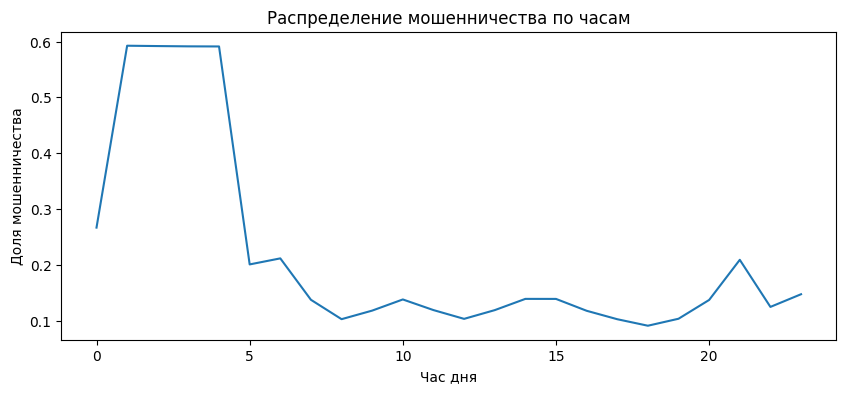

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


cols = ['amount', 'vendor_category', 'card_type', 'channel', 'country', 
        'is_card_present', 'is_outside_home_country', 'is_high_risk_vendor',
        'is_weekend', 'is_fraud', 'timestamp']

transactions = pd.read_parquet(
    'C:/Users/malsh/Downloads/transaction_fraud_data.parquet', 
    columns=cols
)


print(f"Всего транзакций: {len(transactions)}")
print(f"Доля мошенничества: {transactions['is_fraud'].mean():.2%}\n")

# Топ-5 категорий по риску мошенничества
print("Топ-5 рискованных категорий:")
print(transactions.groupby('vendor_category')['is_fraud'].mean().sort_values(ascending=False).head(5))

# Анализ временных паттернов
transactions['hour'] = transactions['timestamp'].dt.hour
hourly_risk = transactions.groupby('hour')['is_fraud'].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=hourly_risk.index, y=hourly_risk.values)
plt.title('Распределение мошенничества по часам')
plt.xlabel('Час дня')
plt.ylabel('Доля мошенничества')
plt.show()

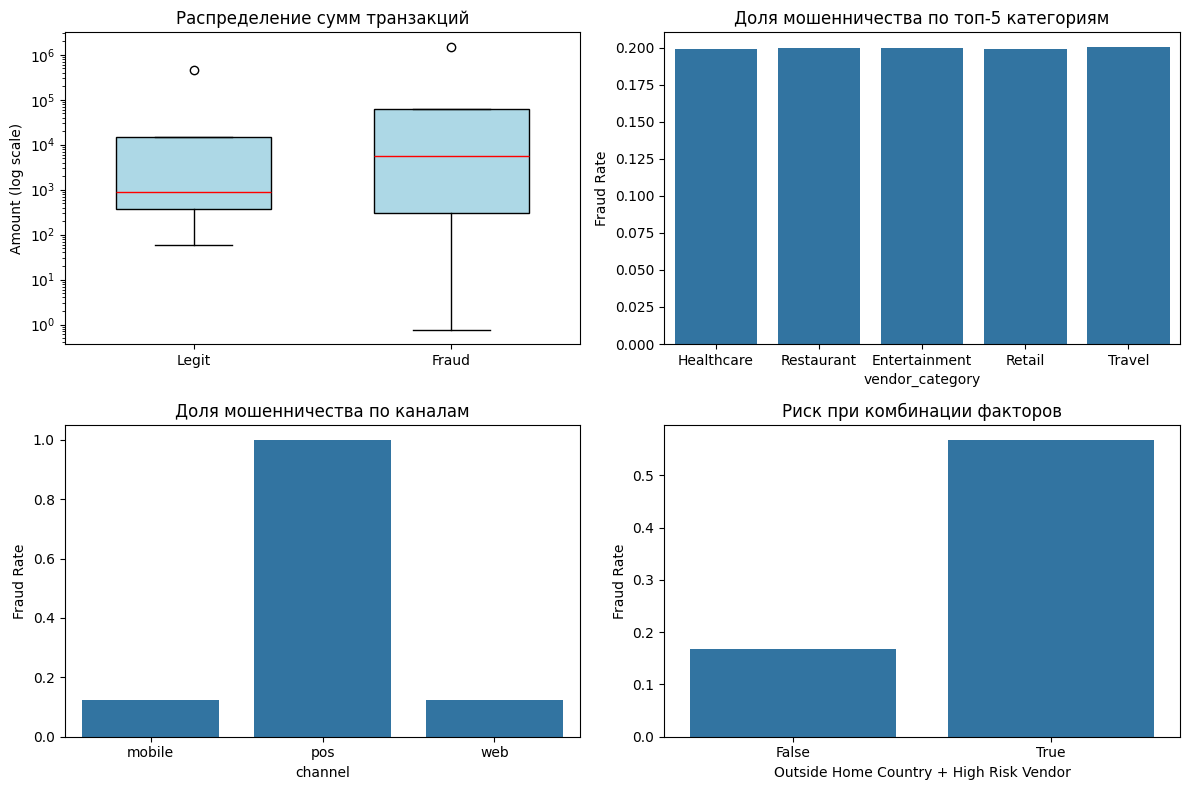

In [12]:
cols = ['amount', 'vendor_category', 'card_type', 'channel', 'country', 
        'is_card_present', 'is_outside_home_country', 'is_high_risk_vendor',
        'is_weekend', 'is_fraud', 'timestamp']

transactions = pd.read_parquet(
    'C:/Users/malsh/Downloads/transaction_fraud_data.parquet', 
    columns=cols
)

plt.figure(figsize=(12, 8))

# Для легитимных операций
legit = transactions[~transactions['is_fraud']]
q_legit = legit['amount'].quantile([0.01, 0.25, 0.5, 0.75, 0.99]).values

# Для мошеннических операций
fraud = transactions[transactions['is_fraud']]
q_fraud = fraud['amount'].quantile([0.01, 0.25, 0.5, 0.75, 0.99]).values

plt.subplot(2, 2, 1)
plt.boxplot([q_legit, q_fraud], 
            positions=[1, 2], 
            widths=0.6,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'))
plt.xticks([1, 2], ['Legit', 'Fraud'])
plt.title('Распределение сумм транзакций')
plt.ylabel('Amount (log scale)')
plt.yscale('log')

# barplot по категориям
plt.subplot(2, 2, 2)
top_cats = transactions['vendor_category'].value_counts().nlargest(5).index
cat_risk = transactions[transactions['vendor_category'].isin(top_cats)].groupby('vendor_category')['is_fraud'].mean().reset_index()
sns.barplot(x='vendor_category', y='is_fraud', data=cat_risk, order=top_cats)
plt.title('Доля мошенничества по топ-5 категориям')
plt.ylabel('Fraud Rate')

# barplot по каналам
plt.subplot(2, 2, 3)
channel_risk = transactions.groupby('channel')['is_fraud'].mean().reset_index()
sns.barplot(x='channel', y='is_fraud', data=channel_risk)
plt.title('Доля мошенничества по каналам')
plt.ylabel('Fraud Rate')

# Комбинированный риск
plt.subplot(2, 2, 4)
transactions['combo_risk'] = transactions['is_outside_home_country'] & transactions['is_high_risk_vendor']
combo_risk = transactions.groupby('combo_risk')['is_fraud'].mean().reset_index()
sns.barplot(x='combo_risk', y='is_fraud', data=combo_risk)
plt.title('Риск при комбинации факторов')
plt.xlabel('Outside Home Country + High Risk Vendor')
plt.ylabel('Fraud Rate')

plt.tight_layout()
plt.show()